In [1]:
import imports as im
import functions as fn
%matplotlib inline

2023-05-25 02:00:27.258927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set path to directory with folders train and test
df = im.pd.read_csv('../data/data/train.csv')
path_train = '../datasets/train_wav/'
path_train_noised = '../datasets/train_wavs_noised_002/'

Create datasets

- train : 80%
- val : 10%
- test : 10%

In [3]:
train_index = int(len(df["clip_name"]) * 0.8)
val_index = train_index + int(len(df["clip_name"]) * 0.1)

In [4]:
x_train_hc, y_train_hc, x_val_hc, y_val_hc, x_test_hc, y_test_hc = fn.create_HC_dataset_wavs(df, train_index, val_index, path_train, Noised=False)

/usr/local/lib/python3.10/site-packages/librosa/feature/spectral.py:2157: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


10.0 % completed
20.0 % completed
30.0 % completed
40.0 % completed
50.0 % completed
60.0 % completed
70.0 % completed
80.0 % completed
90.0 % completed
100.0 % completed


In [ ]:
# create Complexity-Entropy datasets from wav-file with ordpy (work worse and longer, than the previous method)
x_train_hc_ord, y_train_hc_ord, x_val_hc_ord, y_val_hc_ord, x_test_hc_ord, y_test_hc_ord = fn.create_hc_dataset_ordpy(df, path_train, train_index, val_index)

In [5]:
train_data_hc = im.tf.data.Dataset.from_tensor_slices((x_train_hc, y_train_hc))
val_data_hc = im.tf.data.Dataset.from_tensor_slices((x_val_hc, y_val_hc))
test_data_hc = im.tf.data.Dataset.from_tensor_slices((x_test_hc, y_test_hc))

batch_size = 64

train_data_hc = train_data_hc.batch(batch_size)
val_data_hc = val_data_hc.batch(batch_size)
test_data_hc = test_data_hc.batch(batch_size)

2023-05-25 02:15:39.740413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Inception Time

In [6]:
num_classes = 2

def make_model(input_shape):
    input_layer = im.keras.layers.Input(input_shape)

    conv1 = im.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = im.keras.layers.BatchNormalization()(conv1)
    conv1 = im.keras.layers.ReLU()(conv1)

    conv2 = im.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = im.keras.layers.BatchNormalization()(conv2)
    conv2 = im.keras.layers.ReLU()(conv2)

    conv3 = im.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = im.keras.layers.BatchNormalization()(conv3)
    conv3 = im.keras.layers.ReLU()(conv3)

    gap = im.keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = im.keras.layers.Dense(num_classes, activation="softmax")(gap)

    return im.keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=x_train_hc.shape[1:])
im.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [7]:
epochs = 500
weights_inception = "../weights_inception/InceptionTime.h5"

callbacks = [
    im.keras.callbacks.ModelCheckpoint(
        weights_inception, save_best_only=True, monitor="val_loss"
    ),
    im.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    im.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

In [14]:
HistoryInception = model.fit(
    train_data_hc,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_data_hc,
    verbose=1,
)

Epoch 1/10
375/375 [==============================] - 3s 9ms/step - loss: 0.3415 - sparse_categorical_accuracy: 0.8197 - val_loss: 0.4211 - val_sparse_categorical_accuracy: 0.8370 - lr: 1.2500e-04
Epoch 2/10
375/375 [==============================] - 3s 8ms/step - loss: 0.3412 - sparse_categorical_accuracy: 0.8204 - val_loss: 0.4226 - val_sparse_categorical_accuracy: 0.8370 - lr: 1.2500e-04
Epoch 3/10
375/375 [==============================] - 3s 9ms/step - loss: 0.3410 - sparse_categorical_accuracy: 0.8207 - val_loss: 0.4223 - val_sparse_categorical_accuracy: 0.8377 - lr: 1.2500e-04
Epoch 4/10
375/375 [==============================] - 3s 9ms/step - loss: 0.3406 - sparse_categorical_accuracy: 0.8211 - val_loss: 0.4246 - val_sparse_categorical_accuracy: 0.8360 - lr: 1.2500e-04
Epoch 5/10
375/375 [==============================] - 4s 10ms/step - loss: 0.3404 - sparse_categorical_accuracy: 0.8212 - val_loss: 0.4254 - val_sparse_categorical_accuracy: 0.8343 - lr: 1.2500e-04
Epoch 6/10
375

In [15]:
model = im.keras.models.load_model(weights_inception)

test_loss, test_acc = model.evaluate(test_data_hc)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

47/47 [==============================] - 0s 4ms/step - loss: 0.3290 - sparse_categorical_accuracy: 0.8573
Test accuracy 0.8573333621025085
Test loss 0.32895123958587646


In [16]:
metric = "sparse_categorical_accuracy"

AccInception = HistoryInception.history[metric]
ValAccInception = HistoryInception.history["val_" + metric]

EpochsInception = range(1, len(AccInception) + 1)

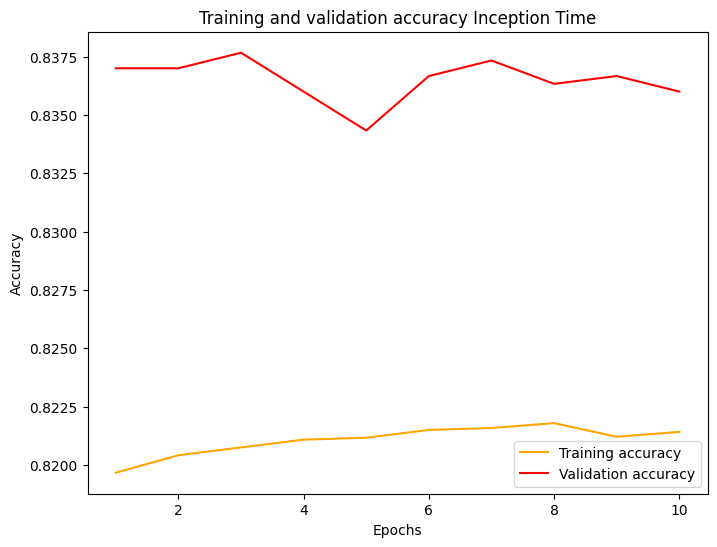

In [17]:
fn.PlotLossAcc(TrainData=AccInception, ValData=ValAccInception, Epochs=EpochsInception,
            TrainLabel='Training accuracy', ValLabel='Validation accuracy',
            yLabel='Accuracy', title='Training and validation accuracy Inception Time',
            ColTrain='orange', ColVal='red', filename="../images/acc_inception.pdf")